In [435]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
import os
from utils import preprocess

%reload_ext autoreload
%autoreload 2

# Load Data

In [436]:
raw_data_dict = {name[:-16]: pd.read_csv(f'data/{name}') for name in os.listdir('data') if name.endswith('(2017-2023).csv')}
dataset = pd.DataFrame(index=raw_data_dict['Apple']['Date'])
for key in sorted(raw_data_dict):
    dataset = pd.merge(
        dataset,
        raw_data_dict[key].set_index('Date').add_prefix(key + ' '),
        on='Date',
    )
dataset.index = pd.to_datetime(dataset.index)

In [437]:
news = pd.concat((
    pd.read_csv('data/News1year.csv', encoding='latin1', header=None, names=['Date','Title','Evaluation', 'Prob'], index_col=0),
    pd.read_csv('data/News5years.csv', encoding='latin1', header=None, names=['Date','Title','Evaluation', 'Prob'], index_col=0),
)).sort_index()
news.index = pd.to_datetime(news.index.map(lambda x: x[:10]))

news['Evaluation'] = news['Evaluation'].map({'negative': 0, 'neutral': 0.5, 'positive': 1})
news_evaluation = pd.Series({date: d['Evaluation'].dot(d['Prob']) / d['Prob'].sum() for date, d in news.groupby('Date')}).rename('News')

dataset = pd.merge(
    dataset,
    news_evaluation.to_frame().add_prefix("Apple "),
    left_index=True,
    right_index=True,
)
dataset = dataset.loc[dataset.index.duplicated(keep="first") == False]

In [438]:
target = 'VIX'

# Add Technical Indicators

In [439]:
dataset = pd.merge(
    dataset, 
    preprocess.get_technical_indicators(dataset[f'{target} Close']).add_prefix(f'{target} '), 
    left_index=True, 
    right_index=True,
    how='left'
).drop_duplicates()

assert len(dataset) == len(set(dataset.index))


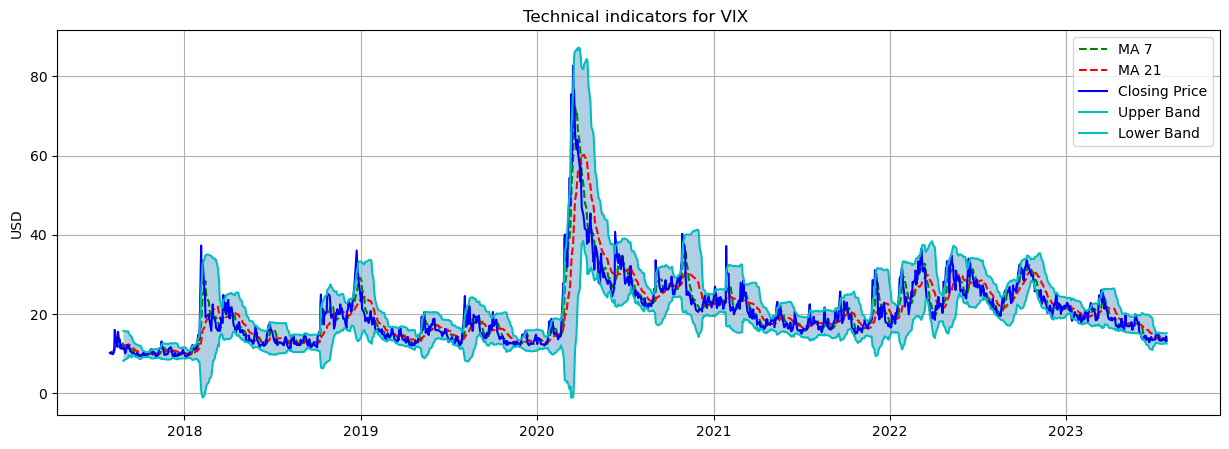

In [440]:
def plot_technical_indicators(dataset, prefix=''):
    plt.figure(figsize=(15, 5))    
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    plt.plot(dataset[prefix+'ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset[prefix+'ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset[prefix+'Close'],label='Closing Price', color='b')
    plt.plot(dataset[prefix+'upper_band'],label='Upper Band', color='c')
    plt.plot(dataset[prefix+'lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset[prefix+'lower_band'], dataset[prefix+'upper_band'], alpha=0.35)
    plt.title(f'Technical indicators for {prefix}')
    plt.ylabel('USD')
    plt.grid()
    plt.legend()

plot_technical_indicators(dataset, f'{target} ')
plt.savefig(f'images/{target} technical indicators.png', bbox_inches='tight', dpi=300)

# Fourier transforms

## IFFT

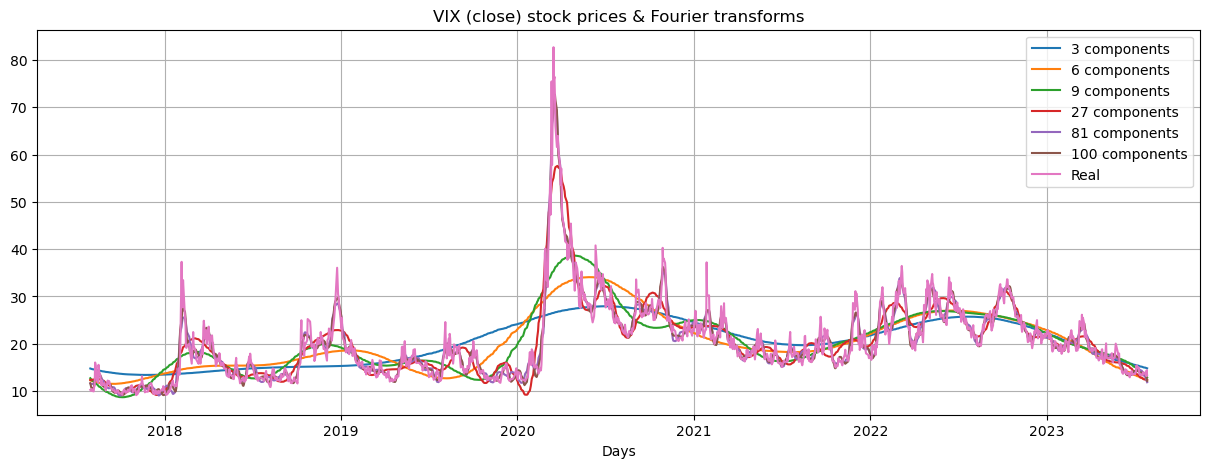

In [441]:
plt.figure(figsize=(15, 5))

data = dataset[f'{target} Close']
fourier_components = preprocess.get_fourier_components(data, [3, 6, 9, 27, 81, 100])

dataset = pd.merge(
    dataset,
    fourier_components,
    left_index=True,
    right_index=True
)
assert len(dataset) == len(set(dataset.index))


for component in fourier_components:
    plt.plot(fourier_components[component], label=component[3:])


    
plt.plot(data,  label='Real')
plt.xlabel('Days')
plt.title(f'{target} (close) stock prices & Fourier transforms')
plt.legend()
plt.grid()
plt.savefig(f'images/{target} (close) stock prices & Fourier transforms.png', dpi=300, bbox_inches='tight')

## STFT

In [442]:
dataset = pd.merge(
    dataset,
    preprocess.get_stft_features(dataset[f'{target} Close'], 10).add_prefix(f'{target} '),
    left_index=True, 
    right_index=True
).drop_duplicates()

assert len(dataset) == len(set(dataset.index))

In [443]:
dataset.index[dataset.index >= datetime(2018, 1, 1)].min()

Timestamp('2018-01-02 00:00:00')

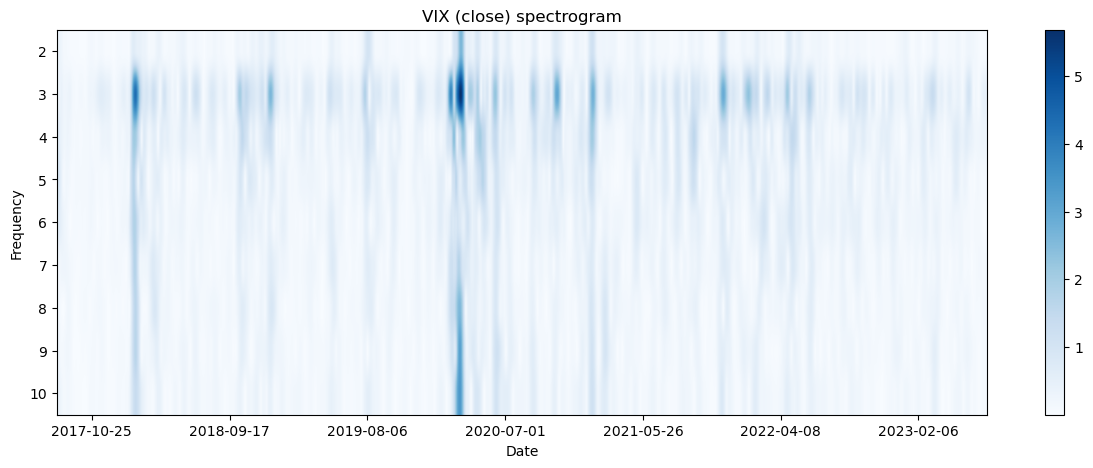

In [444]:
plt.figure(figsize=(15, 5))
plt.imshow(
    dataset[sorted(filter(lambda s: s.split()[-1].startswith('STFT'), dataset.columns))[2:]].T,
    aspect='auto',
    cmap='Blues'
)
plt.colorbar()
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(range(50, len(dataset), 200), [d.date() for d in dataset.index[50::200]], rotation=0)
plt.yticks(range(0, 9), range(2, 11))
plt.title(f'{target} (close) spectrogram')
plt.savefig(f'images/{target} spectrogram.png', dpi=300, bbox_inches='tight')

## DWT

In [445]:
dataset = pd.merge(
    dataset, 
    preprocess.get_wavelet_features(dataset[f'{target} Close']).add_prefix(f'{target} '),
    left_index=True, 
    right_index=True
).drop_duplicates()

assert len(dataset) == len(set(dataset.index))


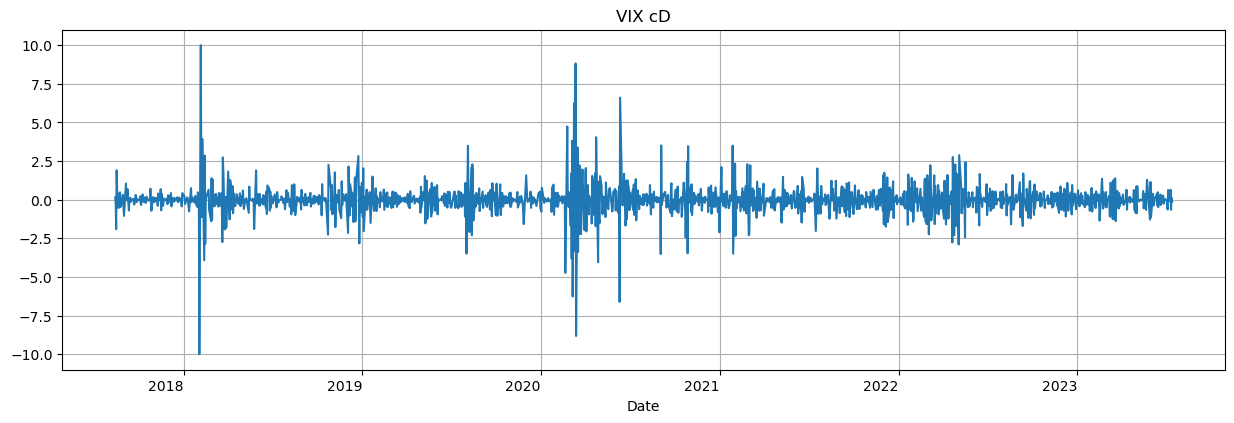

In [446]:
plt.figure(figsize=(15, 5))
dataset[f'{target} cD'].plot(rot=0)
plt.title(f'{target} cD')
plt.xlabel('Date')
plt.grid()
plt.savefig(f'images/{target} cD.png', bbox_inches='tight', dpi=300)

# Save 

In [447]:
dataset.dropna(inplace=True)
dataset.drop_duplicates(inplace=True)
dataset.sort_index(axis=1, inplace=True)
dataset.to_pickle('data/processed_dataset.pkl')

In [448]:
# dataset['Apple News'].plot(
#     figsize=(15, 5), 
#     title='Evalution of news per day', 
#     grid=True, 
#     color='#096A62', 
#     alpha=0.9,
# )
# plt.savefig('images/evalution_per_day.png', bbox_inches='tight', dpi=300)

In [449]:
# dataset['Apple News'].plot(
#     figsize=(15, 5), 
#     title='Number of news per day', 
#     grid=True, 
#     color='#096A62', 
#     alpha=0.9,
# )
# plt.savefig('images/news_per_day.png', bbox_inches='tight', dpi=300)